In [39]:
import numpy as np
from model import *
from mod_v11 import *
import tensorflow as tf
import fastwer
import cv2
from skimage import color

imgs = np.expand_dims(np.load('../generated_text.npz')['arr_0'], axis=-1)
imgs = np.transpose(imgs, (0, 2, 1, 3))
labels = np.load('../generated_labels.npy')
characters = set(char for label in labels for char in label)

t_dist_dim = int(128)

In [98]:
net = build_and_compile_model_v9_7(input_shape=(128, 128, 1), len_characters=len(characters), opt="Adam")
net2 = build_and_compile_model_v11(input_shape=(128, 128, 1), len_characters=len(characters), opt="Adam")
net.load_weights('../CRNN_v9_7.h5')
net2.load_weights('../CRNN_v11.h5')

In [82]:
num_dic = []
for char in sorted(characters):
    num_dic.append(char)
num_dic.append('[UNK]')

def num_to_char(strings):
    rets = []
    for strng in strings:
        ret = []
        for char in strng:
            ret.append(num_dic[char])
        rets.append(ret)
    return np.array(rets)

def decode_ctc(args):
    """returns a list of decoded ctc losses"""

    y_pred, input_length = args

    ctc_decoded = tf.keras.backend.ctc_decode(
        y_pred, input_length, greedy=True)

    return ctc_decoded

def encoding_to_label(pred):
    lst = []
    for label in pred:
        b = label.squeeze()[np.argwhere(label.squeeze()!='[UNK]')]
        tmp = ''
        if len(b) == 1:
            tmp = b[0][0]
        else:
            for char in b.squeeze():
                tmp += char
        lst.append(tmp)
    return lst

def predict_text(imgs, net, t_dist_dim):
    if len(imgs.shape) == 3:
        imgs = np.expand_dims(imgs, axis=0)
    t_dim = np.full((imgs.shape[0],), t_dist_dim)
    pred_tensor, _ = decode_ctc([net.predict(imgs), t_dim])
    pred_labels = tf.keras.backend.get_value(pred_tensor[0])
    return encoding_to_label(num_to_char(pred_labels))

def predict_random_text(size, gen, net, t_dist_dim):
    preds = []
    y_true = []
    for _ in range(size):
        img, lbl = next(gen)
        y_true.append(lbl)
        im = cv2.resize(np.array(img), (128, 128))
        im = color.rgb2gray(im)
        im = np.expand_dims(im, axis=-1)
        im = np.transpose(im, (1, 0, 2))
        pred_tensor, _ = decode_ctc([net.predict(np.expand_dims(im, axis=0)), np.array([t_dist_dim])])
        pred_labels = tf.keras.backend.get_value(pred_tensor[0])
        preds.append(encoding_to_label(num_to_char(pred_labels).numpy())[0])
    return preds, y_true

def predict_phrase(phrase_img, net, tdist_dim):
    im = color.rgb2gray(np.array(phrase_img))
    saltpepper = cv2.fastNlMeansDenoising(np.uint8(im*255),None, 13,2)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
    dilated = cv2.dilate(1-saltpepper, kernel)
    dilated[dilated > 128] = 255
    dilated[dilated <= 128] = 0
    contours, hierarchy = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours = sorted(contours, key=lambda c: min(min(c[:, :, 0])))
    words = []
    
    for i in range(len(contours)):
        mask = np.zeros((im.shape[0], im.shape[1]), dtype=np.uint8)

        # i is the contour to draw, -1 means fill the contours
        mask = cv2.drawContours(mask, contours, i, 255, -1)
        masked_img = cv2.bitwise_and(255-saltpepper, 255-saltpepper, mask=mask)
        masked_img[masked_img<=90] = 0
        masked_img = masked_img/255
        masked_img = 1-masked_img
        #masked_img[masked_img>=0.9] = 0.86
        masked_img = cv2.resize(masked_img, (128, 128))
        masked_img = np.expand_dims(masked_img, axis=-1)
        masked_img = np.transpose(masked_img, (1, 0, 2))
        words.append(masked_img)

    return predict_text(np.array(words), net, tdist_dim)


def predict_random_phrase_1(net, gen, n_samples, t_dist_dim):
    preds = []
    y_true = []
    for _ in range(n_samples):
        img, lbl = next(gen)
        y_true.append(lbl)
        pred = predict_phrase(img, net, t_dist_dim)
        preds.append(phrase_prediction_to_string(pred))
    return preds, y_true

def predict_random_phrase_2(net, gen, n_samples, t_dist_dim):
    preds = []
    y_true = []
    for _ in range(n_samples):
        img, lbl = next(gen)
        y_true.append(lbl)
        pred = predict_phrase_2(img, net, t_dist_dim)
        preds.append(phrase_prediction_to_string(pred))
    return preds, y_true

def predict_phrases(net, imgs, t_dist_dim):
    preds = []
    for im in imgs:
        pred = predict_phrase(im, net, t_dist_dim)
        preds.append(phrase_prediction_to_string(pred))
    return preds

def predict_phrases_2(net, imgs, t_dist_dim):
    preds = []
    for im in imgs:
        pred = predict_phrase_2(im, net, t_dist_dim)
        preds.append(phrase_prediction_to_string(pred))
    return preds

def predict_phrase_2(phrase_img, net, tdist_dim):
    im = color.rgb2gray(np.array(phrase_img))
    saltpepper = cv2.fastNlMeansDenoising(np.uint8(im*255),None, 13,2)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
    dilated = cv2.dilate(1-saltpepper, kernel)
    dilated[dilated > 128] = 255
    dilated[dilated <= 128] = 0
    contours, hierarchy = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours = sorted(contours, key=lambda c: min(min(c[:, :, 0])))
    words = []
    
    for i in range(len(contours)):
        mask = np.zeros((im.shape[0], im.shape[1]), dtype=np.uint8)

        # i is the contour to draw, -1 means fill the contours
        mask = cv2.drawContours(mask, contours, i, 255, -1)
        masked_img = cv2.bitwise_and(255-saltpepper, 255-saltpepper, mask=mask)
        masked_img[masked_img<=90] = 0
        masked_img = masked_img/255
        masked_img = 1-masked_img
        x, y, w, h = cv2.boundingRect(contours[i])
        crop_word = masked_img[y:y+h,x:x+w]
        if w > 128:
            crop_word = cv2.resize(crop_word, (128,h))
            w = 128    
        masked_img = np.ones((32,128))
        startx = (128 - w)//2
        starty = (32 - h)//2
        masked_img[starty:starty+h, startx:startx+w] = crop_word
        masked_img = cv2.resize(masked_img, (128, 128))
        masked_img = np.expand_dims(masked_img, axis=-1)
        masked_img = np.transpose(masked_img, (1, 0, 2))
        words.append(masked_img)
    return predict_text(np.array(words), net, tdist_dim)

def phrase_prediction_to_string(predictions):
    result = ""
    for word in predictions:
        result+=word+" "
    result=result[:-1]
    return result

def generate_testset(dim, gen):
    test_set = []
    y_true = []
    for _ in range(dim):
        img, lbl = next(gen)
        y_true.append(lbl)
        test_set.append(img)
    return test_set, y_true

In [18]:
import cv2
from skimage import color
from trdg.generators import GeneratorFromRandom, GeneratorFromWikipedia

base_generator = GeneratorFromRandom(use_symbols=False, use_letters=True, length=1, width=180, size=32, space_width=2.0)
#base_generator = GeneratorFromWikipedia(width=180, size=32, space_width=2.0)

In [41]:
training_preds = predict_text(imgs, net2, t_dist_dim)

In [42]:
#Metrica su training set
score = 0
for i in range(len(training_preds)):
    score += fastwer.score_sent(training_preds[i], labels[i], char_level=True)
score = score / len(training_preds)
print(score)

1.3738529700000013


In [12]:
#Metrica su test set
test_preds, test_labels = predict_random_text(500, base_generator, net, t_dist_dim)
test_score = 0
for i in range(len(test_preds)):
    test_score += fastwer.score_sent(test_preds[i], test_labels[i], char_level=True)
test_score = test_score / len(test_preds)
print(test_score)

3.423968199999999


In [51]:
test_preds

['3qiaahawn5ka9nilvrk', 'OvicoIa', 'Binomialname', 'kM8yb6848lbhiaA']

In [52]:
test_labels

['clade Heterobranchiaclade Euthyneuraclade Panpulmonata',
 'O vicola',
 'Binomial name',
 'Odostomia vicolaDall Bartsch 1909']

In [70]:
test_set = []
y_true = []
for _ in range(5000):
    img, lbl = next(base_generator)
    y_true.append(lbl)
    im = cv2.resize(np.array(img), (128, 128))
    im = color.rgb2gray(im)
    im = np.expand_dims(im, axis=-1)
    im = np.transpose(im, (1, 0, 2))
    test_set.append(im)
test_set = np.array(test_set)

In [71]:
pred_1 = predict_text(test_set, net, t_dist_dim)
pred_2 = predict_text(test_set, net2, t_dist_dim)

In [72]:
test_score1 = 0
test_score2 = 0
for i in range(len(test_set)):
    test_score1 += fastwer.score_sent(pred_1[i], y_true[i], char_level=True)
    test_score2 += fastwer.score_sent(pred_2[i], y_true[i], char_level=True)
test_score1 = test_score1 / len(pred_1)
test_score2 = test_score2 / len(pred_2)
print(test_score1)
print(test_score2)

3.0066504400000027
2.9954759000000033


Prediction su frasi, separando le parole

In [44]:
import matplotlib.pyplot as plt

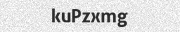

In [20]:
img, _ = next(base_generator)
im = cv2.resize(np.array(img), (128, 128))
im = color.rgb2gray(im)
im = np.expand_dims(im, axis=-1)
im = np.transpose(im, (1, 0, 2))
display(img)

In [17]:
im = color.rgb2gray(np.array(img))

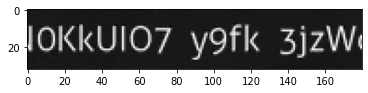

In [80]:
saltpepper = cv2.fastNlMeansDenoising(np.uint8(im*255),None, 13,2)
plt.imshow(255-saltpepper, cmap='gray')
plt.show()

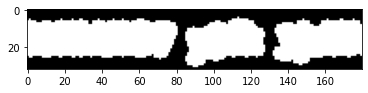

In [81]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
dilated = cv2.dilate(1-saltpepper, kernel)
dilated[dilated > 128] = 255
dilated[dilated <= 128] = 0
plt.imshow(dilated, cmap='gray')
plt.show()

In [82]:
contours, hierarchy = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contours = sorted(contours, key=lambda c: min(min(c[:, :, 0])))
words = []
for i in range(len(contours)):

    mask = np.zeros((32, 180), dtype=np.uint8)

    # i is the contour to draw, -1 means fill the contours
    mask = cv2.drawContours(mask, contours, i, 255, -1)
    masked_img = cv2.bitwise_and(255-saltpepper, 255-saltpepper, mask=mask)
    masked_img[masked_img<=90] = 0
    masked_img = masked_img/255
    masked_img = 1-masked_img
    #masked_img[masked_img>=0.9] = 0.86
    words.append(masked_img)

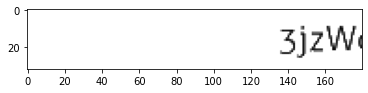

In [90]:
plt.imshow(words[2], cmap='gray')
plt.show()

In [87]:
test_img = cv2.resize(words[0], (128, 128))
test_img = np.expand_dims(test_img, axis=-1)
test_img = np.transpose(test_img, (1, 0, 2))

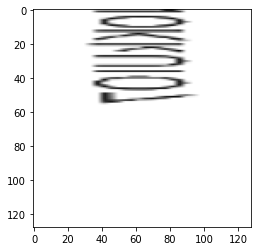

In [88]:
plt.imshow(test_img, cmap='gray')
plt.show()

In [344]:
pred_tensor, _ = decode_ctc([net2.predict(np.expand_dims(test_img, axis=0)), np.array([t_dist_dim])])
pred_labels = tf.keras.backend.get_value(pred_tensor[0])

In [345]:
pred_labels

array([[11, 47, 36, 46, 40, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]])

In [346]:
num_to_char(pred_labels)

<tf.Tensor: shape=(1, 128), dtype=string, numpy=
array([[b'B', b'l', b'a', b'k', b'e', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',

In [13]:
predict_phrase_2(np.array(img), net2, t_dist_dim)

['0x', 'g92FFTHFB8', 'PN1']

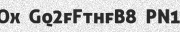

In [14]:
display(img)

In [15]:
predict_phrase(np.array(img), net2, t_dist_dim)

['0x', 'Gq2ffthfB8', 'PN1']

In [221]:
ws = [i for i in range(128, 500, 4)]
test_scores_1_cer = []
test_scores_2_cer = []
test_scores_1_wer = []
test_scores_2_wer = []
for w in ws:
    base_generator = GeneratorFromRandom(use_symbols=False, use_letters=True, length = 2, width=w, size=32, space_width=2.0)
    test_imgs, test_labels = generate_testset(200, base_generator)
    test_preds_1 = predict_phrases(net2, test_imgs, t_dist_dim)
    test_preds_2 = predict_phrases_2(net2, test_imgs, t_dist_dim)
    test_score_1_cer = 0
    test_score_1_wer = 0
    test_score_2_cer = 0
    test_score_2_wer = 0
    for i in range(len(test_preds_1)):
        test_score_1_cer += fastwer.score_sent(test_preds_1[i], test_labels[i], char_level=True)
        test_score_2_cer += fastwer.score_sent(test_preds_2[i], test_labels[i], char_level=True)
        test_score_1_wer += fastwer.score_sent(test_preds_1[i], test_labels[i], char_level=False)
        test_score_2_wer += fastwer.score_sent(test_preds_2[i], test_labels[i], char_level=False)
    test_score_1_cer = test_score_1_cer / len(test_preds_1)
    test_score_2_cer = test_score_2_cer / len(test_preds_1)
    test_score_1_wer = test_score_1_wer / len(test_preds_1)
    test_score_2_wer = test_score_2_wer / len(test_preds_1)
    test_scores_1_cer.append(test_score_1_cer)
    test_scores_2_cer.append(test_score_2_cer)
    test_scores_1_wer.append(test_score_1_wer)
    test_scores_2_wer.append(test_score_2_wer)
    print('Lunghezza: ' + str(w))
    print('CER 1: ' + str(test_score_1_cer))
    print('CER 2: ' + str(test_score_2_cer))
    print('WER 1: ' + str(test_score_1_wer))
    print('WER 2: ' + str(test_score_2_wer))
    print('--------------------------------------')

Lunghezza: 128
CER 1: 23.730052000000004
CER 2: 47.313902999999975
WER 1: 75.5
WER 2: 93.0
--------------------------------------
Lunghezza: 132
CER 1: 21.298651999999993
CER 2: 44.8323585
WER 1: 72.5
WER 2: 94.75
--------------------------------------
Lunghezza: 136
CER 1: 22.297096000000007
CER 2: 44.07246250000001
WER 1: 73.25
WER 2: 93.5
--------------------------------------
Lunghezza: 140
CER 1: 22.28724649999999
CER 2: 46.048128
WER 1: 72.5
WER 2: 95.75
--------------------------------------
Lunghezza: 144
CER 1: 21.48247149999999
CER 2: 43.14549749999999
WER 1: 76.0
WER 2: 94.75
--------------------------------------
Lunghezza: 148
CER 1: 18.840536
CER 2: 44.8594125
WER 1: 65.5
WER 2: 95.25
--------------------------------------
Lunghezza: 152
CER 1: 18.7464795
CER 2: 41.90474949999999
WER 1: 64.75
WER 2: 88.75
--------------------------------------
Lunghezza: 156
CER 1: 20.907093500000006
CER 2: 42.01406749999999
WER 1: 71.5
WER 2: 88.0
--------------------------------------
L

ValueError: Expect x to be a non-empty array or dataset.

In [208]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [225]:
ws = [i for i in range(128, 409, 4)]

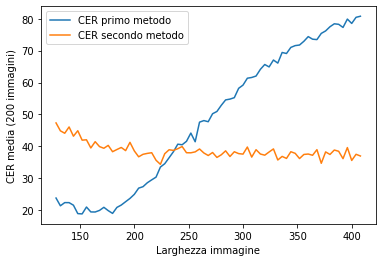

In [227]:
plt.plot(ws, test_scores_1_cer, label='CER primo metodo')
plt.plot(ws, test_scores_2_cer, label='CER secondo metodo')
plt.xlabel('Larghezza immagine')
plt.ylabel('CER media (200 immagini)')
plt.legend()
plt.show()

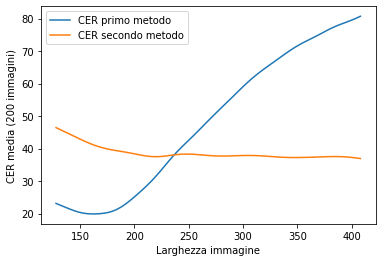

In [228]:
from statsmodels.nonparametric.kernel_regression import KernelReg
kr1 = KernelReg(test_scores_1_cer,ws,'c')
kr2 = KernelReg(test_scores_2_cer,ws,'c')
y_pred_1, y_std_1 = kr1.fit(ws)
y_pred_2, y_std_2 = kr2.fit(ws)

plt.plot(ws, y_pred_1, label='CER primo metodo')
plt.plot(ws, y_pred_2, label='CER secondo metodo')
plt.xlabel('Larghezza immagine')
plt.ylabel('CER media (200 immagini)')
plt.legend()
plt.show()

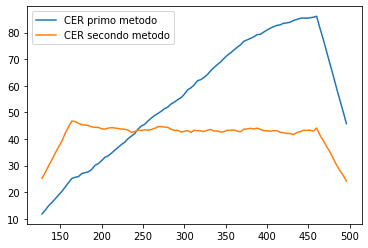

In [210]:
plt.plot(ws, smooth(test_scores_1_cer, 19), label='CER primo metodo')
plt.plot(ws, smooth(test_scores_2_cer, 19), label='CER secondo metodo')
plt.legend()
plt.show()

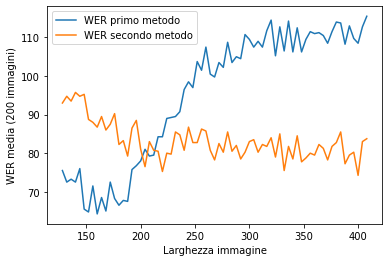

In [231]:
plt.plot(ws, test_scores_1_wer, label='WER primo metodo')
plt.plot(ws, test_scores_2_wer, label='WER secondo metodo')
plt.xlabel('Larghezza immagine')
plt.ylabel('WER media (200 immagini)')
plt.legend()
plt.show()

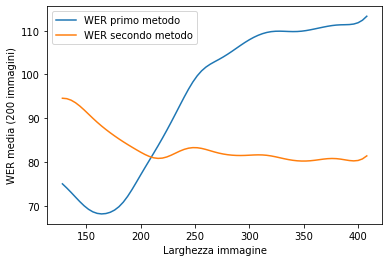

In [232]:
from statsmodels.nonparametric.kernel_regression import KernelReg
kr1 = KernelReg(test_scores_1_wer,ws,'c')
kr2 = KernelReg(test_scores_2_wer,ws,'c')
y_pred_1, y_std_1 = kr1.fit(ws)
y_pred_2, y_std_2 = kr2.fit(ws)

plt.plot(ws, y_pred_1, label='WER primo metodo')
plt.plot(ws, y_pred_2, label='WER secondo metodo')
plt.xlabel('Larghezza immagine')
plt.ylabel('WER media (200 immagini)')
plt.legend()
plt.show()

In [195]:
base_generator = GeneratorFromRandom(use_symbols=False, use_letters=True, length = 1, width=128, size=32)

In [196]:
test_imgs, test_labels = generate_testset(10, base_generator)

In [197]:
preds, labels = predict_random_phrase_1(net2, base_generator, 10, t_dist_dim)

In [207]:
predict_phrase(test_imgs[4], net2, t_dist_dim) 

['SR']

In [79]:
np.array(test_imgs[0]).shape

(32, 200, 3)

In [77]:
import matplotlib.pyplot as plt

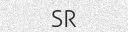

In [206]:
test_imgs[4]

In [170]:
test_imgs, test_labels = generate_testset(10, base_generator)

In [181]:
test_preds_2 = predict_phrases(net2, test_imgs, t_dist_dim)

In [182]:
test_labels

['Aq BoEihW5DH8',
 'dtmVm9 t6o',
 'H9FX dIVDmlUc',
 'Z9xy 3vn',
 'zPanIDWPW fY5YvhS4N',
 'Kr6C 4s',
 '8Y A14',
 'bR ZDr6yn3S',
 '9MEE1uHvT 7fm5sz',
 'MVf eyHv7']

In [183]:
test_preds_2

['hapofnwspro',
 '4tmvm9eso',
 'r9fxgIvpnIve',
 '49ryvn',
 'ipanipwpwfysvvnshn',
 'xrbc 4s',
 'pvAHa',
 'nm9',
 '',
 'mvfeYhv']

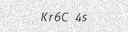

In [177]:
test_imgs[5]